In [49]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.features import shapes as rio_shapes
from shapely.geometry import shape
from shapely.geometry.multipolygon import MultiPolygon
import geopandas as gpd
from skimage.segmentation import felzenszwalb

from preprocess import data_extractor, resize_ndvi
from utilefunc.get_band_order_GS2 import get_band_order_GS2
from utilefunc.resample import resample
from construct_bb_set import construct_bb_set
from final_bb_constraint import final_bb_constraint

import os
from osgeo import gdal, gdal_array
#from dtw import *
#import dtw
%matplotlib widget
from matplotlib import pyplot as plt

In [50]:
# Parameter settings
## segmentation parameters 
scale=5          # controls the number of produced segments as well as their size. Higher scale means less and larger segments. 
sigma=0          # diameter of a Gaussian kernel, used for smoothing the image prior to segmentation.
min_size=5       # minimum size of the segment

## BB selection and graph construction parameters
alpha = 0.4
# min_bb_size = 5  # if from big to small, no big influence
t1 = 0.1
t2 = 0           # not used in the work
direction=1      # 0 : from small to big; 1: from big to small


In [51]:
## general data informations
fields_data_fpath = 'pinnote_anomaly_info/annotations_dates_params.csv'   # path for a list of season field ids
data_path = 'data_images_2017_2020/'  # path for image time series, each stocked in a file folder named with its sfd_id

fields_data = pd.read_csv(fields_data_fpath, sep=';')  # a file of season field ids with year
sfd_ids = fields_data['sfd_id'].unique()  # all season field ids to process 

In [52]:
#fields_data['sfd_id'] == 102000576
#ields_data['sfd_id'].value_counts() # 1743 values

In [53]:
sfd_ids # 43 field with 563 records --> too many just- For example just 2 image

array([102000576, 102002234, 102006104, 102008580, 102009130, 102019060,
       102058667, 102066519, 102077408, 102103879, 102112067, 102112829,
       102130079, 102169942, 102174002, 102196644, 102196663, 102203873,
       102247581, 102248701, 102252397, 102268387, 102328550, 102358920,
       102403591, 102424640, 102474637, 102536577, 102564105, 102620833,
       102622198, 102623113, 102627215, 102645549, 102670816, 102721937,
       102750316, 102750358, 102873222, 102923614, 102943146, 103016841,
       103023037], dtype=int64)

In [54]:
# Take 1 seasonal fields 
sfd_ids = np.array([102112829]) # sfd_ids
sfd_ids
#len(sfd_ids)

array([102112829])

In [55]:
# save paths - change into 2023 for checking algorithms
save_path_df = 'variables_2023/raster_df/scale_{0}/'.format(scale)
if direction == 0:
    save_path_bb = 'variables_2023/BB_evolution_graph/BB_small2big/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
    save_path_shp = 'variables_2023/sfd_bbs_cover/BB_small2big/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
if direction == 1:
    save_path_bb = 'variables_2023/BB_evolution_graph/BB_big2small/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)
    save_path_shp = 'variables_2023/sfd_bbs_cover/BB_big2small/scale_{0}_alpha_{1}_t1_{2}_t2_{3}/'.format(scale, alpha, t1, t2)


In [56]:
import math
### Generate the img_ndvi_tif
def Generate_Segmentation_Image(segments_test):     
    NoImage = len(segments_test)
    ncols = 4    
    NoRows = int(math.ceil(NoImage/ncols))
    plt.close('all')
    fig, ax = plt.subplots(nrows= NoRows , ncols=ncols , figsize=(15,8) )    
    for idx,img in enumerate(segments_test):        
        #cmap, norm = get_palette(ndvi_image)
        row,col = idx//ncols, idx%ncols        
        #ax[row][col].set_title(f'{DATE[idx]}')
        a = ax[row][col].imshow(
            img,
            #cmap='RdYlGn',
        )        
        ax[row][col].axis('off')        
        # Set the colorbar scale
        #a.set_clim(vmin=0, vmax=1)
        
    #fig.colorbar(a, ax=ax[:,:])
    #fig.suptitle(f'Segmentation Images of {sfd_id} from {DATE[0]} to {DATE[-1]}')    
    '''
    if not os.path.exists(f'{savePath}/Segmentation/{sfd_id}/'):
        os.makedirs( f'{savePath}/Segmentation/{sfd_id}/')
    fig.savefig(f'{savePath}/Segmentation/{sfd_id}/{Date}.png ',format='png')        
    '''    
    plt.show()    

In [129]:
if band_gil_file.size >= 2:  # each time series need at least 2 images
    # ---------- Step 2 : Image data preprocessing
    # prepare for ndvi image resizing, the 'mask_dict' saves an unified standard image size for the time series of a field
    mask_dict, tif_info = resize_ndvi(data_path, ndvi_tif_file, sfd_id_choice)

    raster_df = []
    date = []
    todelete = []
    for i in range(len(band_gil_file)):
        # for each image in the satellite image time series for the sfd_id
        if band_gil_file[i].split('_')[3] in ['Sentinel2', 'Landsat8']: # we choose only these 2 satellite capteurs
            img_band_gil = data_path + str(sfd_id_choice)+ '/' + band_gil_file[i]
            img_band_tif = data_path + str(sfd_id_choice) + '/' + band_tif_file[i]
            img_ndvi_tif = data_path + str(sfd_id_choice) + '/' + ndvi_tif_file[i]  
            # Bands and NDVI images are listed by the same date order
            date.append(band_gil_file[i].split('_')[2]) 

            # raster band
            bands_green_red_nir = get_band_order_GS2(img_band_gil, ['green', 'red', 'nir'])
            raster_band = rasterio.open(img_band_tif)
            raster_band_numpy = raster_band.read(bands_green_red_nir, masked=True) # attention masked # channel order meaning : (3, height, width)

            # raster ndvi
            raster_ndvi = rasterio.open(img_ndvi_tif)
            raster_ndvi_numpy = raster_ndvi.read(1, masked=True) # NDVI image only one channel
            # resize the NDVI image to the standard size
            raster_ndvi_numpy = resample(raster_ndvi_numpy, mask_dict[sfd_id_choice])   

            # resize bands image according to the already unified NDVI image of the same date
            raster_resampled_1 = resample(raster_band_numpy[0,:,:], raster_ndvi_numpy).filled(np.nan)
            raster_resampled_2 = resample(raster_band_numpy[1,:,:], raster_ndvi_numpy).filled(np.nan)
            raster_resampled_3 = resample(raster_band_numpy[2,:,:], raster_ndvi_numpy).filled(np.nan)
            raster_band_numpy_resampled = np.stack((raster_resampled_1, raster_resampled_2, raster_resampled_3), axis=0)            
            raster_band_numpy_resampled = np.ma.masked_invalid(raster_band_numpy_resampled) # channel : (3, height, width) # raster_band_numpy resampled with mask # not filled() 

    # ---------- Step 3 : Segmentation 
            # parameter 'scale' can be set proportional to the number of valide pixels in this image
            # num_valid_pixels = np.sum(~raster_band_numpy_resampled[0,:,:].mask)
            # scale = num_valid_pixels//100

            # segment each band image 
            raster_band_numpy_seg = np.transpose(raster_band_numpy_resampled, (1,2,0)) # channel : (width, height, 3) ndarray for segmentation of bande images            
            raster_band_numpy_seg = raster_band_numpy_seg.filled(-1)
            segments_fz = felzenszwalb(raster_band_numpy_seg, scale=scale, sigma=sigma, min_size=min_size)

            raster_df.append([raster_band_numpy_seg, segments_fz, raster_ndvi_numpy])
        else:
            todelete.append(i)

    band_tif_file = np.delete(band_tif_file, todelete, 0)
    raster_df = pd.DataFrame(raster_df, index=pd.to_datetime(date, format='%Y-%m-%d'), columns=['raster_band_numpy_seg', 'segments_fz', 'raster_ndvi_numpy']).sort_index() # sort_index because the date labels may not be in order

    # # save data for future analysis
    # if not os.path.exists(save_path_df):
    #     os.makedirs(save_path_df)
    # raster_df.to_pickle(save_path_df+'{0}_{1}_scale_{2}_raster_seg_df.pkl'.format(sfd_id_choice,year_choice,scale))

    # ---------- Step 4 : Bounding Box selection
    segments_test = raster_df['segments_fz']
    raster_ndvi_numpy_test = raster_df['raster_ndvi_numpy']
    bb_final_list_1 = construct_bb_set(segments_test, alpha, direction) # give min_bb_size if needed

    # ---------- Step 5 : Evolution graph construction            
    ## Constraint final BB and construct graphs
    bb_final_list = final_bb_constraint(bb_final_list_1, segments_test, t1, t2)

    ## delete BBs of invalid data (masked) zones
    todelete = []
    for i in range(bb_final_list.shape[0]):
        date_choice = segments_test.index[bb_final_list[i,0]].strftime('%Y-%m-%d')
        raster_ndvi_numpy = raster_df.loc[date_choice, 'raster_ndvi_numpy']
        segments_fz = raster_df.loc[date_choice, 'segments_fz']
        ###### delete graphs related to areas of masked invalid pixels 
        if raster_ndvi_numpy.mask[segments_fz == bb_final_list[i,1]].size !=0 and sum(raster_ndvi_numpy.mask[segments_fz == bb_final_list[i,1]])/raster_ndvi_numpy.mask[segments_fz == bb_final_list[i,1]].size >= 0.9:
            todelete.append(i)
    bb_final_list = np.delete(bb_final_list, todelete, 0)

    # save data for future analysis
    # if not os.path.exists(save_path_bb):
    #     os.makedirs(save_path_bb)
    # np.save(save_path_bb+'{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_final_bb.npy'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2), bb_final_list)

    # create geodataframe of all BBs' coverage for each field and save it in shapefile
    sdf = []
    for idx in range(0, bb_final_list.shape[0]):
        np_array = np.zeros(mask_dict[sfd_id_choice].shape, dtype=np.uint8)
        np_array[segments_test.iloc[bb_final_list[idx, 0]] == bb_final_list[idx, 1]] = 1.0
        df = pd.DataFrame(rio_shapes(np_array, transform=tif_info['transform']), columns=['geometry_dict', 'value'])
        df = df[df.value > 0]
        gdf = gpd.GeoDataFrame(df[['value']], geometry=df['geometry_dict'].apply(shape))
        sdf.append([sfd_id_choice, str(bb_final_list[idx,0])+'_'+str(bb_final_list[idx,1]),
                    date[bb_final_list[idx,0]], band_tif_file[bb_final_list[idx,0]], 
                    bb_final_list[idx, 1], tif_info['EPSG'], MultiPolygon(gdf['geometry'].values)]) 
    sdf = pd.DataFrame(sdf, columns=['sfd_id', 'BB_id', 'BB_date', 'BB_pos_img', 'BB_seg_id', 'EPSG', 'geometry']) 
    sfd_bb_geo_df = gpd.GeoDataFrame(sdf, geometry=sdf['geometry'], crs="EPSG:{}".format(tif_info['EPSG'])).to_crs(4326)

    #save data for future analysis
    # if not os.path.exists(save_path_shp):
    #     os.makedirs(save_path_shp)
    # sfd_bb_geo_df.to_file(save_path_shp+'{0}_{1}_scale_{2}_alpha_{3}_t1_{4}_t2_{5}_bbscover.shp'.format(sfd_id_choice,year_choice,scale,alpha,t1,t2))

float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


In [106]:
#sfd_bb_geo_df

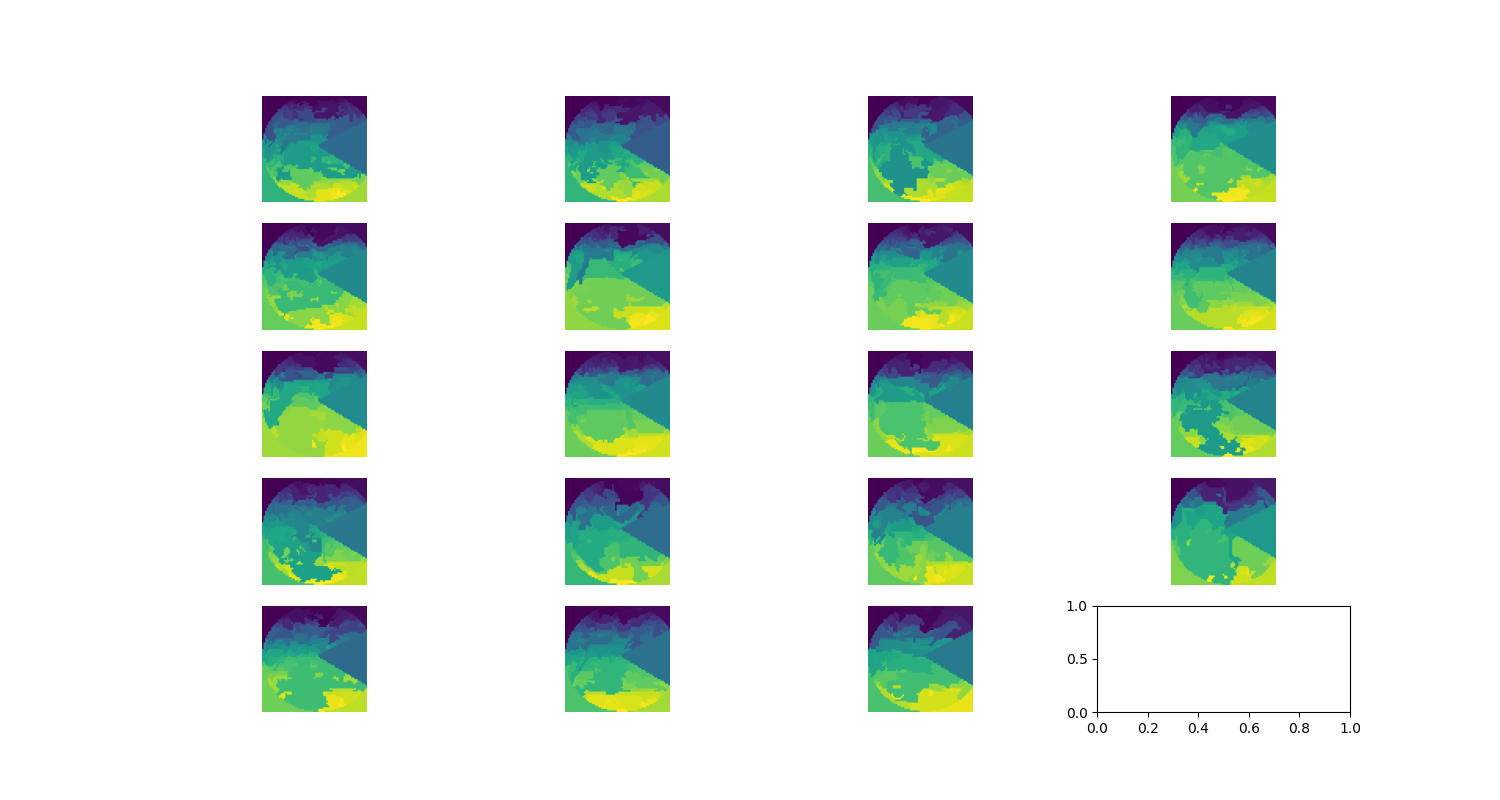

In [61]:
Generate_Segmentation_Image(segments_test)

In [116]:
raster_band_numpy_resampled[0].filled(-1)

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

In [127]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)    

pd.DataFrame(raster_band_numpy[2])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.243812,0.243400,0.243400,0.242988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.253499,0.253471,0.252998,0.251845,0.249910,0.246651,0.243812,0.242988,0.241377,0.239589,0.238911,0.238923,0.240468,0.241459,0.243501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.261208,0.261089,0.260884,0.258512,0.253499,0.253444,0.252052,0.250038,0.247639,0.245112,0.242622,0.240516,0.239381,0.238868,0.238484,0.239418,0.243501,0.247259,0.252272,0.253902,0.255348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263680,0.264028,0.263460,0.261208,0.260970,0.260475,0.259102,0.257179,0.254854,0.252107,0.248903,0.245589,0.242238,0.239637,0.238923,0.239033,0.238813,0.239821,0.244069,0.249013,0.252455,0.255348,0.261766,0.265236,0.266482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.243025,0.248363,0.255683,0.263680,0.264376,0.264577,0.267013,0.268679,0.266848,0.263332,0.258846,0.254158,0.250423,0.247438,0.245552,0.244307,0.243263,0.242695,0.242293,0.243318,0.247823,0.253243,0.257546,0.261245,0.263991,0.266482,0.271966,0.275811,0.277853,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.200342,0.218952,0.243025,0.253700,0.262325,0.265255,0.266884,0.272066,0.275857,0.273971,0.269393,0.263186,0.256923,0.252785,0.250111,0.249416,0.249361,0.248354,0.247621,0.247621,0.249104,0.253719,0.259175,0.263698,0.267287,0.268532,0.269759,0.273769,0.277853,0.274404,0.276040,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.182562,0.186084,0.200342,0.213489,0.236360,0.258901,0.266738,0.270254,0.276736,0.281021,0.279189,0.274593,0.268954,0.263076,0.258498,0.254744,0.251613,0.249837,0.250423,0.252437,0.255367,0.259084,0.263955,0.268184,0.270107,0.269851,0.265200,0.261354,0.264046,0.269320,0.276040,0.273708,0.277029,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.221345,0.196570,0.182562,0.175347,0.185693,0.217866,0.252052,0.265181,0.271261,0.277816,0.281240,0.279446,0.275344,0.271261,0.266884,0.262746,0.258571,0.253224,0.249837,0.252254,0.257088,0.262490,0.267763,0.271920,0.274081,0.272817,0.268661,0.259560,0.251961,0.253078,0.258571,0.268056,0.277029,0.273086,0.272506,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,0.252748,0.233815,0.221345,0.185803,0.173717,0.177636,0.204828,0.236598,0.254195,0.265053,0.269668,0.270016,0.267727,0.264394,0.262526,0.261007,0.259780,0.258260,0.254726,0.252730,0.256648,0.262197,0.266628,0.269778,0.270363,0.268899,0.264943,0.259999,0.254854,0.251411,0.252327,0.256044,0.262893,0.269723,0.272506,0.268587,0.268148,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,0.257143,0.254665,0.252748,0.227351,0.199701,0.185162,0.182525,0.200397,0.224604,0.244050,0.258132,0.260091,0.257216,0.254524,0.252052,0.251997,0.253041,0.254964,0.256648,0.255934,0.255824,0.259835,0.264248,0.266408,0.266591,0.263662,0.259340,0.254341,0.250624,0.251338,0.253536,0.254854,0.256575,0.259450,0.262636,0.265108,0.268148,0.267757,0.268551,NaN


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


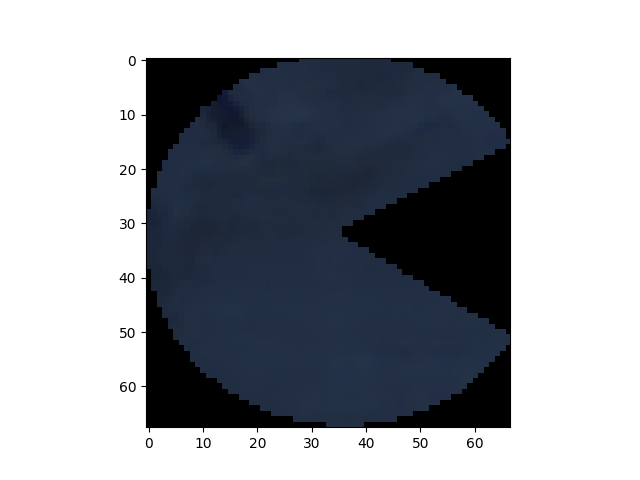

In [110]:
data = raster_band_numpy_seg
plt.close('all')
plt.imshow( data,
           #cmap='RdYlGn',
          )
plt.show()

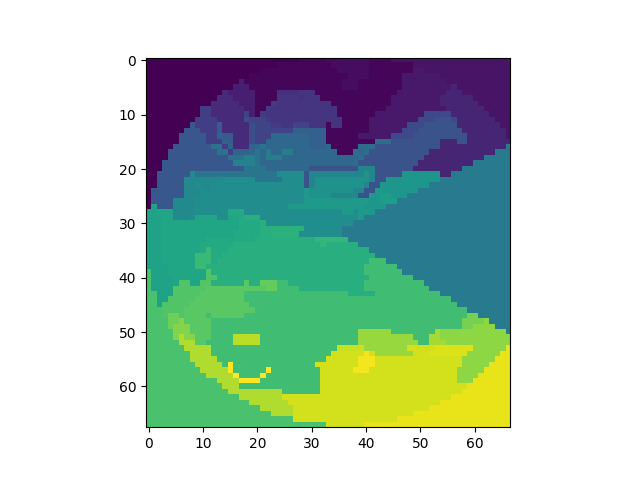

In [104]:
data = segments_fz
plt.close('all')
plt.imshow( data,
           #cmap='RdYlGn',
          )
plt.show()

In [ ]:
segments_fz